📂 Please upload your CSV file (e.g., twitter_training.csv)...


Saving twitter_training (1).csv to twitter_training (1) (1).csv


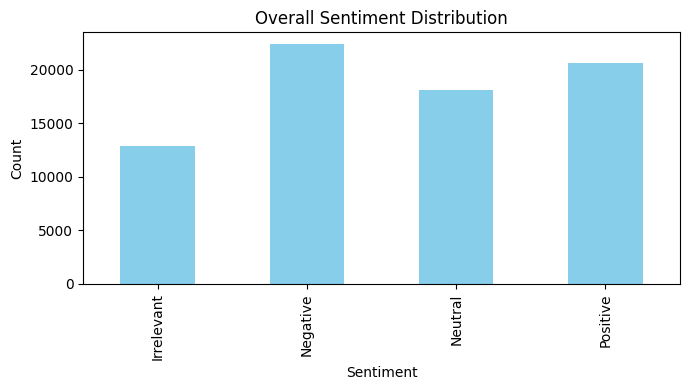

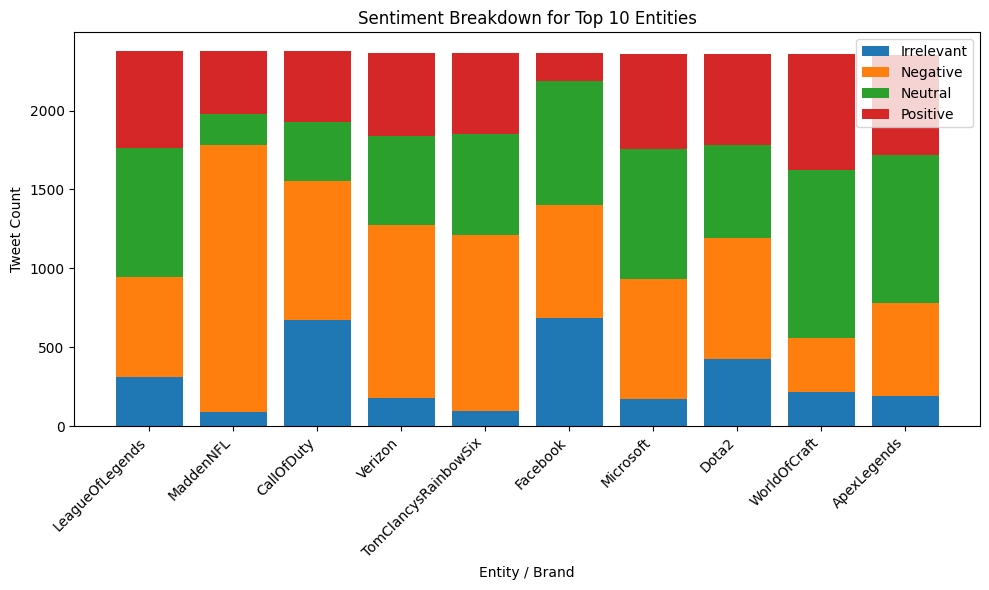

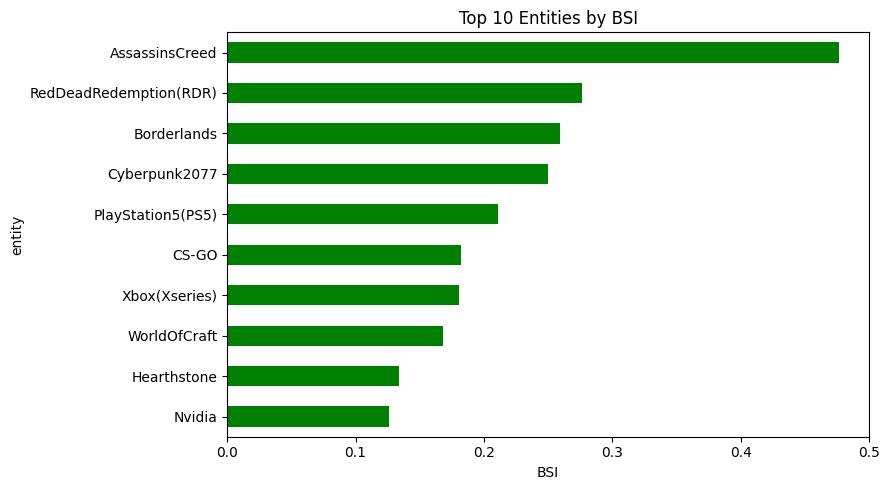

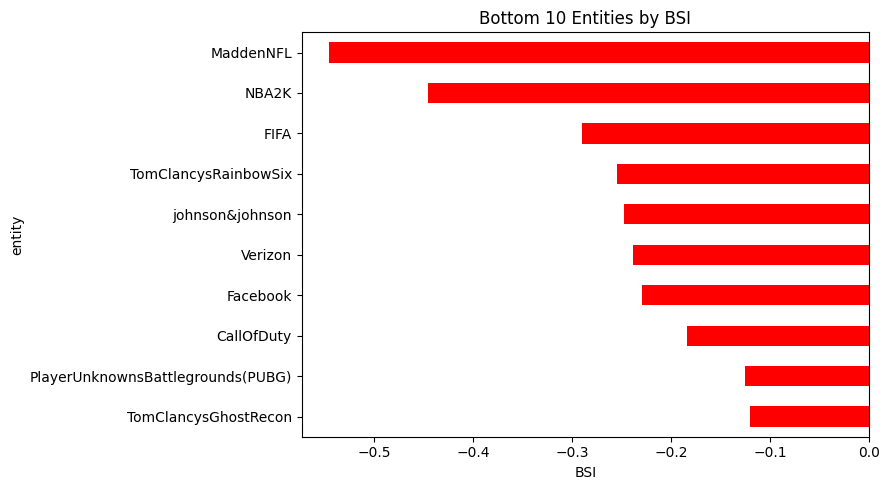


📊 Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.89      0.82      0.85      2575
    Negative       0.89      0.89      0.89      4472
     Neutral       0.89      0.84      0.86      3622
    Positive       0.82      0.90      0.85      4131

    accuracy                           0.87     14800
   macro avg       0.87      0.86      0.87     14800
weighted avg       0.87      0.87      0.87     14800

Weighted F1: 0.8672645428683112
Macro F1: 0.8653394868471813


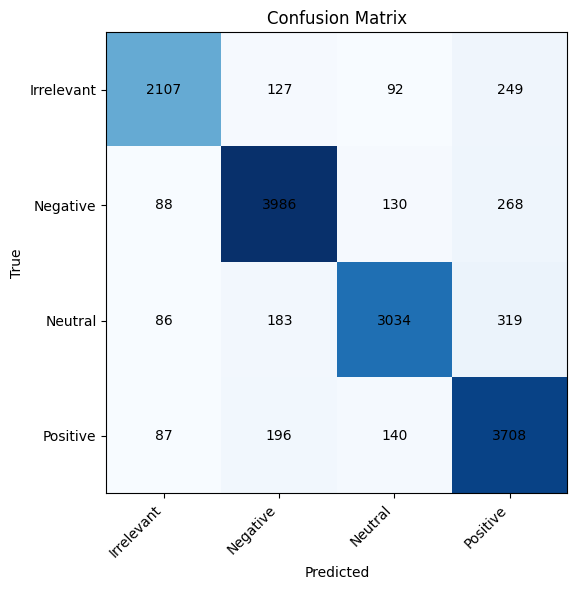


✅ Analysis complete. All charts are saved in the 'figures/' folder.


In [1]:

# Task 04: Sentiment Analysis & Visualization in Google Colab


# Step 1: Install required packages (Colab usually has them pre-installed)
!pip install pandas numpy matplotlib scikit-learn --quiet

# Step 2: Import libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from google.colab import files

# Step 3: Upload dataset
print("📂 Please upload your CSV file (e.g., twitter_training.csv)...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 4: Load dataset
col_names = ["tweet_id", "entity", "sentiment", "tweet"]
df = pd.read_csv(filename, header=None, names=col_names, encoding="utf-8", engine="python", on_bad_lines="skip")
df = df.dropna(subset=["entity", "sentiment", "tweet"]).reset_index(drop=True)

# Step 5: Clean/normalize text
URL_PATTERN = re.compile(r"(http[s]?://\S+|www\.\S+)")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")
NON_LETTER_PATTERN = re.compile(r"[^a-zA-Z\s]")

def clean_text(text: str) -> str:
    t = text.lower()
    t = URL_PATTERN.sub(" url ", t)
    t = MENTION_PATTERN.sub(" user ", t)
    t = HASHTAG_PATTERN.sub(r"\1", t)
    t = NON_LETTER_PATTERN.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["tweet_clean"] = df["tweet"].astype(str).apply(clean_text)
df["sentiment"] = df["sentiment"].astype(str).str.strip().str.title()

# Step 6: Sentiment distribution plot
sent_counts = df["sentiment"].value_counts().sort_index()
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7, 4))
sent_counts.plot(kind="bar", color="skyblue")
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/overall_sentiment_distribution.png", dpi=150)
plt.show()

# Step 7: Sentiment by top entities
TOP_N = 10
top_entities = df["entity"].value_counts().head(TOP_N).index.tolist()
df_top = df[df["entity"].isin(top_entities)].copy()

pivot_counts = pd.pivot_table(
    df_top, index="entity", columns="sentiment", values="tweet_id",
    aggfunc="count", fill_value=0
).reindex(index=top_entities)

plt.figure(figsize=(10, 6))
bottom = None
for s in sorted(pivot_counts.columns):
    values = pivot_counts[s].values
    if bottom is None:
        plt.bar(pivot_counts.index, values, label=s)
        bottom = values
    else:
        plt.bar(pivot_counts.index, values, bottom=bottom, label=s)
        bottom = bottom + values
plt.xticks(rotation=45, ha="right")
plt.title(f"Sentiment Breakdown for Top {TOP_N} Entities")
plt.xlabel("Entity / Brand")
plt.ylabel("Tweet Count")
plt.legend()
plt.tight_layout()
plt.savefig("figures/sentiment_by_top_entities.png", dpi=150)
plt.show()

# Step 8: Brand Sentiment Index (BSI)
entity_group = df.groupby("entity")["sentiment"].value_counts().unstack(fill_value=0)
entity_group["Total"] = entity_group.sum(axis=1)
entity_group["Positive"] = entity_group.filter(like="Pos", axis=1).sum(axis=1)
entity_group["Negative"] = entity_group.filter(like="Neg", axis=1).sum(axis=1)
entity_group["BSI"] = (entity_group["Positive"] - entity_group["Negative"]) / entity_group["Total"]

eligible = entity_group[entity_group["Total"] >= 50]

# Best 10
best_10 = eligible.sort_values("BSI", ascending=False).head(10)
plt.figure(figsize=(9, 5))
best_10["BSI"].iloc[::-1].plot(kind="barh", color="green")
plt.title("Top 10 Entities by BSI")
plt.xlabel("BSI")
plt.tight_layout()
plt.savefig("figures/top10_bsi.png", dpi=150)
plt.show()

# Worst 10
worst_10 = eligible.sort_values("BSI", ascending=True).head(10)
plt.figure(figsize=(9, 5))
worst_10["BSI"].iloc[::-1].plot(kind="barh", color="red")
plt.title("Bottom 10 Entities by BSI")
plt.xlabel("BSI")
plt.tight_layout()
plt.savefig("figures/bottom10_bsi.png", dpi=150)
plt.show()

# Step 9: Train baseline classifier
X_train, X_test, y_train, y_test = train_test_split(
    df["tweet_clean"], df["sentiment"].values, test_size=0.2, random_state=42, stratify=df["sentiment"].values
)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000, stop_words="english")
Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)

clf = LinearSVC()
clf.fit(Xtr, y_train)
y_pred = clf.predict(Xte)

# Step 10: Show metrics
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

# Confusion matrix
labels = sorted(pd.unique(np.concatenate([y_train, y_test])))
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(6.5, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("figures/confusion_matrix.png", dpi=150)
plt.show()

print("\n✅ Analysis complete. All charts are saved in the 'figures/' folder.")
